This code is the dummy code that:

Input: 
- random "fidelity" F from 0 to 1
- property P that was calculated from F

Output:
- Macchine learned `model` that given P output a predicted F

In [45]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from qutip import *
import matplotlib.pyplot as plt
from visualisation_tools import *
from model_generator import *
from qsq_protocol import *

In [46]:
experiment_prob_failing(rho_ideal,S_gate,M_ideal)
average_fidelity(rho_ideal,S_gate,M_ideal)

np.float64(1.0)

In [47]:
rho_exp = rand_dm(2)
M_exp = ket2dm(rand_ket(2))
gate_exp = rand_unitary(2)
experiment_prob_failing(rho_exp,gate_exp,M_exp)
average_fidelity(rho_exp,gate_exp,M_exp)

np.float64(0.740324)

In [48]:
def depolarize(rho, p):
    """Apply depolarizing noise with probability p to state rho."""
    dim = rho.shape[0]
    return (1 - p) * rho + p * qeye(dim) / dim

In [49]:
# Example: Generate a grid of 20 theta steps and 40 phi steps
theta_steps = 5  # Number of steps for theta (polar angle)
phi_steps = 5     # Number of steps for phi (azimuthal angle)
density_matrices = generate_density_matrices(theta_steps, phi_steps)

# Check that there's no repetitions
uniform_dm = []
seen_matrices = set()

for rho in density_matrices:
    matrix_repr = str(rho)  # Convert Qobj to its string representation
    if matrix_repr not in seen_matrices:
        uniform_dm.append(rho)
        seen_matrices.add(matrix_repr)

# visualize_dm_on_bloch(uniform_dm)

In [50]:
import itertools
import random

# Number of units and iterations

N_uniform = 400
N_random = 200
N_perturbed = 2000

# Generate uniform unitary matrices and data
uniform_U = generate_random_unitaries(N_uniform)
uniform_data = [
    (dm1, unitary, dm2)
    for dm1, unitary, dm2 in itertools.product([rho_ideal], uniform_U, [M_ideal])
]

# Generate random data
random_data = [
    [rho_ideal, rand_unitary(2), M_ideal]
    for _ in range(N_random)
]

# Generate perturbed unitary matrices and data
perturbed_U = generate_perturbed_unitary(S_gate, N_perturbed,0.5)
perturbed_data = [
    (dm1, unitary, dm2)
    for dm1, unitary, dm2 in itertools.product([rho_ideal], perturbed_U, [M_ideal])
]


In [51]:

# Combine all data into one list
full_data = random_data + uniform_data + perturbed_data

# Shuffle the combined data
random.shuffle(full_data)

# Print the lengths of all datasets
print(f"Length of uniform_data: {len(uniform_data)}")
print(f"Length of random_data: {len(random_data)}")
print(f"Length of perturbed_data: {len(perturbed_data)}")
print(f"Length of full_data: {len(full_data)}")


Length of uniform_data: 400
Length of random_data: 200
Length of perturbed_data: 2000
Length of full_data: 2600


In [52]:
F = []
P = []
for datum in full_data:
    rho_exp = datum[0]
    gate_exp = datum[1]
    M_exp = datum[2]
    F.append(average_fidelity(rho_exp,gate_exp,M_exp))
    P.append(experiment_prob_failing(rho_exp,gate_exp,M_exp))

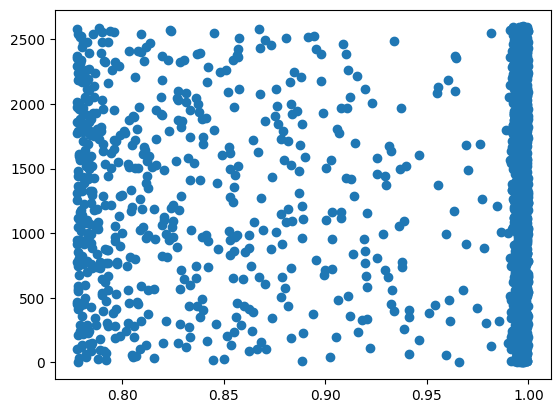

In [53]:
plt.scatter(F,range(len(F)))

In [54]:
# Convert to PyTorch tensors
X = torch.tensor(P, dtype=torch.float32)   # inputs: 3 probabilities
y = torch.tensor(F, dtype=torch.float32).unsqueeze(1)  # output: fidelity

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# -----------------------------
# Simple MLP model
# -----------------------------
# model = nn.Sequential(
#     nn.Linear(3, 32),
#     nn.ReLU(),
#     nn.Linear(32, 32),
#     nn.ReLU(),
#     nn.Linear(32, 1)
# )

model = nn.Sequential(
    nn.Linear(3, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(32, 1)
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -----------------------------
# Training loop
# -----------------------------
epochs = 50
for epoch in range(epochs):
    for xb, yb in dataloader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")


Epoch 10, Loss: 0.021394
Epoch 20, Loss: 0.019145
Epoch 30, Loss: 0.008624
Epoch 40, Loss: 0.007709
Epoch 50, Loss: 0.004702


In [57]:

N_uniform = 40
N_random = 20
N_perturbed = 100

# Generate uniform unitary matrices and data
uniform_U = generate_random_unitaries(N_uniform)
uniform_data = [
    (dm1, unitary, dm2)
    for dm1, unitary, dm2 in itertools.product([rho_ideal], uniform_U, [M_ideal])
]

# Generate random data
random_data = [
    [rho_ideal, rand_unitary(2), M_ideal]
    for _ in range(N_random)
]

# Generate perturbed unitary matrices and data
perturbed_U = generate_perturbed_unitary(S_gate, N_perturbed)
perturbed_data = [
    (dm1, unitary, dm2)
    for dm1, unitary, dm2 in itertools.product([rho_ideal], perturbed_U, [M_ideal])
]

# Combine all data into one list
test_data = random_data + uniform_data + perturbed_data

# Shuffle the combined data
random.shuffle(test_data)

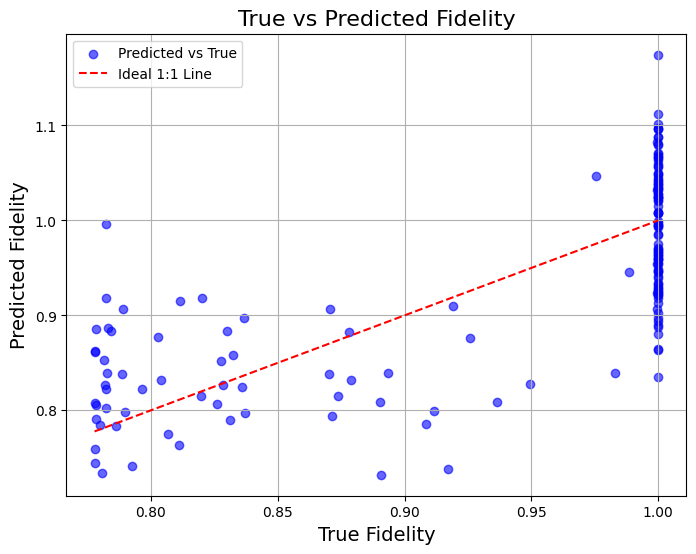

In [58]:
# -----------------------------
# Test prediction
# -----------------------------
true_fidelities = []
pred_fidelities = []

# Loop over multiple test cases
for datum in test_data:
    rho_exp = datum[0]
    gate_exp = datum[1]
    M_exp = datum[2]
    # Get the test probability and fidelity
    test_P = torch.tensor(experiment_prob_failing(rho_exp, gate_exp, M_exp)).unsqueeze(0)  # Batch dimension (1 sample)
    test_F = average_fidelity(rho_exp, gate_exp, M_exp)

    # Get the model prediction
    pred_F = model(test_P).detach().numpy().flatten()

    # Store the results
    true_fidelities.append(test_F)
    pred_fidelities.append(pred_F)

# Convert lists to numpy arrays for plotting
true_fidelities = np.array(true_fidelities)
pred_fidelities = np.array(pred_fidelities)

# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(8, 6))

# Scatter plot of true vs predicted fidelities
plt.scatter(true_fidelities, pred_fidelities, color='blue', label='Predicted vs True', alpha=0.6)

# Plot ideal 1:1 line (perfect prediction)
plt.plot([min(true_fidelities), max(true_fidelities)], [min(true_fidelities), max(true_fidelities)], 'r--', label='Ideal 1:1 Line')

# Labels and title
plt.xlabel("True Fidelity", fontsize=14)
plt.ylabel("Predicted Fidelity", fontsize=14)
plt.title("True vs Predicted Fidelity", fontsize=16)

# Show grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()